In [131]:
import sys
print(sys.version)

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [369]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy.stats import variation

#set max columns displayed to 100
pd.set_option('display.max_columns',100)

### TRAIN DATASET

In [3]:
# First, let's import the train dataset: daily historical data from January 2013 to October 2015.
sales = pd.read_csv('./Data/competitive-data-science-predict-future-sales/sales_train.csv')

In [4]:
sales.shape

(2935849, 6)

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Per Kaggle documentation, the columns in this dataset are:

- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

In [8]:
# Let's convert the date column from string to datetime type
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [194]:
sales.date.describe()

count                 2935843
unique                   1034
top       2013-12-28 00:00:00
freq                     9434
first     2013-01-01 00:00:00
last      2015-10-31 00:00:00
Name: date, dtype: object

In [264]:
#check that there is datetime value for each day between the first and last day in the dataset
(sales.date.max() - sales.date.min()).days + 1

1034

**FINDING:** The number of days between the first and last dates in the dataset matches the number of unique dates in the dataset, so there are no gaps in dates.

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [10]:
# Determine if there are any null values in the dataset
sales.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [11]:
# Determine if there are any duplicate rows in the dataset
sales.duplicated().any()

True

In [12]:
# Determine how many duplicate rows exists
sales.duplicated().sum()

6

In [13]:
# Drop duplicate rows
sales.drop_duplicates(inplace=True)
sales.shape

(2935843, 6)

In [14]:
# Determine the number of unique shop_id values in the dataset
len(sales.shop_id.value_counts())

60

In [15]:
# Determine the number of unique item_id values in the dataset
len(sales.item_id.value_counts())

21807

In [180]:
# Check that the date_block_num column was constructed accurately (i.e., it corresponds to month of date column)

def month_counter(d1):
    '''Calculates number of months between January 2013 and specified date.
    '''
    return (d1.year - datetime.datetime(2013,1,1).year) * 12 + d1.month - datetime.datetime(2013,1,1).month

match_chck = (sales.date.apply(month_counter) != sales.date_block_num).sum()

match_chck

0

**FINDING:** The date_block_num column accurately reflects the month of the date column value.

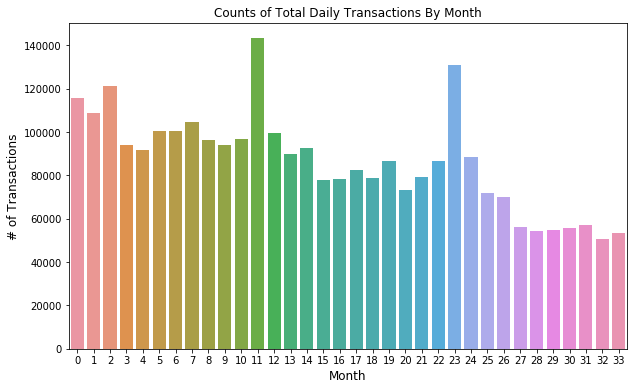

In [16]:
# Check how many total sales transactions there are in each month
monthly_sales_totals = sales.date_block_num.value_counts()
plt.figure(figsize=(10,6))
ax = sns.barplot(monthly_sales_totals.index, monthly_sales_totals.values)
plt.title("Counts of Total Daily Transactions By Month")
plt.ylabel("# of Transactions", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.show()

<b>FINDING:</b> December appears to be a high-volume month, while May appears to be a low-volume month. Other months also point to seasonality of the volume of purchases.

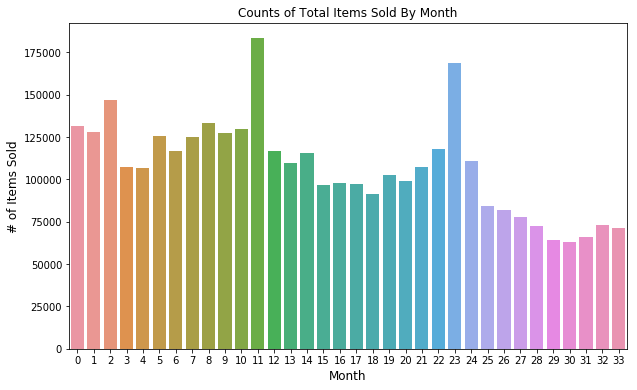

In [158]:
# Check how many total items were sold in each month
monthly_item_totals = sales.groupby("date_block_num")["item_cnt_day"].sum()
plt.figure(figsize=(10,6))
ax = sns.barplot(monthly_item_totals.index, monthly_item_totals.values)
plt.title("Counts of Total Items Sold By Month")
plt.ylabel("# of Items Sold", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.show()

**FINDING:** Looking at monthly totals from the number of items sold perspective, we still see that December is a high-volume month, but there are small differences in this chart and the chart above that looks at item-shop-level totals by month. We also see that there is an apparent downward trend over the whole period.

In [17]:
# Check distribution of month of transaction values for each shop
sales.groupby('shop_id')['date_block_num'].describe().T

shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,9857.000000,5678.000000,25991.000000,25532.000000,38242.000000,38179.000000,82663.000000,58076.000000,3412.000000,3751.000000,21397.000000,499.0,34694.000000,17824.000000,36979.000000,59511.000000,52734.000000,22950.000000,53227.000000,63911.000000,1792.000000,58132.000000,45434.000000,6963.000000,53032.000000,186103.000000,53910.000000,105366.000000,142234.000000,49225.000000,50860.000000,235636.000000,7947.000000,5027.000000,5752.000000,58445.000000,306.0,39638.000000,46013.000000,13440.000000,4257.000000,41967.000000,109252.000000,39282.000000,39530.000000,35891.000000,66321.000000,56695.000000,21612.000000,15849.000000,65171.000000,44433.000000,43502.000000,52921.000000,143479.000000,34769.000000,69573.000000,117428.000000,71441.000000,42108.000000
mean,0.513747,0.525537,16.691855,15.927424,14.507740,16.520574,14.063269,14.853365,0.866061,18.944548,14.182128,25.0,17.484407,8.456744,14.700533,14.258725,13.562768,14.227015,13.454600,14.484893,26.671875,16.161907,14.645134,1.455838,14.689207,15.066350,14.201428,14.513154,14.811283,12.077583,11.074479,14.935341,2.489493,22.950467,25.989221,15.249722,33.0,13.845653,15.883055,23.520833,19.662203,13.466080,16.135860,11.758133,13.824817,13.846424,14.360851,16.592927,23.830326,22.462300,12.459576,12.461166,14.641879,14.886699,11.852585,20.666513,14.301511,15.116378,15.726432,14.301320
std,0.499836,0.499391,9.547010,9.418781,9.549651,9.146677,9.330895,9.427724,0.814302,9.239632,9.400191,0.0,9.643071,5.431443,9.883468,9.416648,9.712060,5.544127,9.855083,9.548045,5.992693,9.580284,9.705284,1.104115,9.148441,9.728439,9.559257,8.786275,9.454782,8.199808,7.322799,9.544102,1.689229,1.883741,4.242381,9.494405,0.0,10.126074,9.655999,5.709685,3.279946,9.151204,9.779877,7.241830,9.341741,9.315826,9.456020,9.641717,5.209350,6.223397,8.846800,8.930045,9.437649,9.377312,7.832074,7.897850,9.329751,8.872493,8.875159,9.560465
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,0.000000,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,18.000000,0.000000,33.0,0.000000,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,2.000000,2.000000,0.000000
25%,0.000000,0.000000,9.000000,8.000000,7.000000,9.000000,6.000000,7.000000,0.000000,9.000000,6.000000,25.0,10.000000,4.000000,6.000000,6.000000,5.000000,10.000000,5.000000,6.000000,21.000000,8.000000,6.000000,0.000000,7.000000,7.000000,6.000000,7.000000,7.000000,5.000000,5.000000,7.000000,1.000000,22.000000,23.000000,7.000000,33.0,4.000000,8.000000,19.000000,17.000000,6.000000,8.000000,6.000000,6.000000,6.000000,6.000000,9.000000,19.000000,17.000000,5.000000,5.000000,7.000000,7.000000,5.000000,15.000000,6.000000,7.000000,8.000000,6.000000
50%,1.000000,1.000000,17.000000,16.000000,14.000000,16.000000,13.000000,14.000000,1.000000,21.000000,13.000000,25.0,18.000000,8.000000,14.000000,13.000000,12.000000,14.000000,11.000000,13.000000,21.000000,16.000000,13.000000,1.000000,13.000000,14.000000,13.000000,14.000000,14.000000,11.000000,11.000000,14.000000,2.000000,23.000000,26.000000,14.000000,33.0,12.000000,16.000000,23.000000,20.000000,12.000000,16.000000,11.000000,13.000000,12.000000,13.000000,17.000000,23.000000,23.000000,11.000000,11.000000,14.000000,14.000000,11.000000,22.000000,13.000000,14.000000,15.000000,13.000000
75%,1.000000,1.000000,24.000000,24.000000,23.000000,24.000000,22.000000,23.000000,2.000000,21.000000,22.000000,25.0,25.000000,13.000000,23.000000,22.000000,22.000000,19.000000,22.000000,23.000000,33.000000,24.000000,23.000000,2.000000,22.000000,23.0000

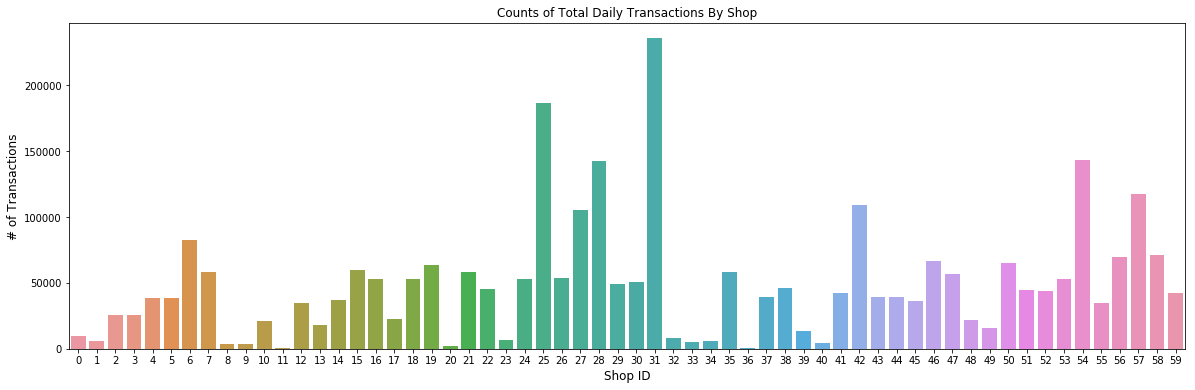

In [18]:
# Visualize differences in total transaction counts across all shops
shop_tx_cts = sales.groupby('shop_id').size()
plt.figure(figsize=(20,6))
ax = sns.barplot(shop_tx_cts.index, shop_tx_cts.values)
plt.title("Counts of Total Daily Transactions By Shop")
plt.ylabel("# of Transactions", fontsize=12)
plt.xlabel("Shop ID", fontsize=12)
plt.show()

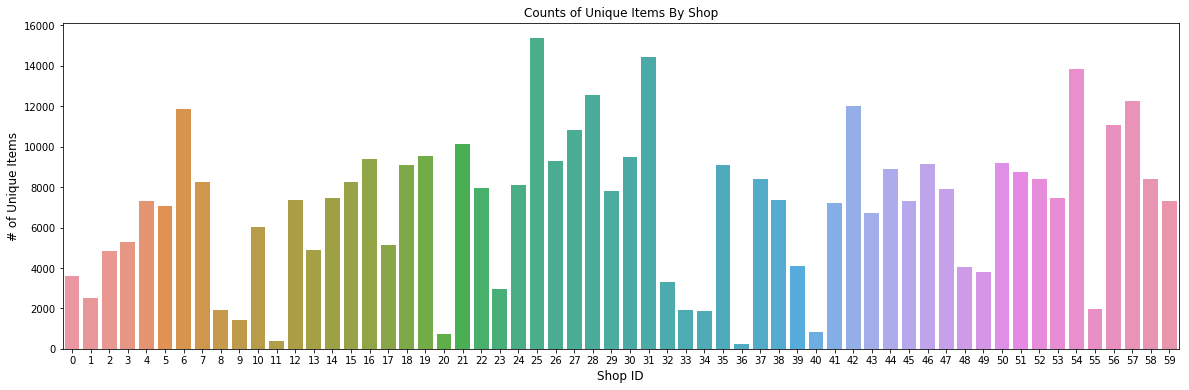

In [19]:
# Check the distribution of the number of unique items per shop
unique_items_by_shop = sales.groupby('shop_id')['item_id'].unique()
unique_item_cts_by_shop = unique_items_by_shop.map(len)
plt.figure(figsize=(20,6))
ax = sns.barplot(unique_item_cts_by_shop.index, unique_item_cts_by_shop.values)
plt.title("Counts of Unique Items By Shop")
plt.ylabel("# of Unique Items", fontsize=12)
plt.xlabel("Shop ID", fontsize=12)
plt.show()

In [20]:
# Check if there are changes in prices for same item
prices_by_item = sales.groupby('item_id')['item_price'].agg(['min','max']).reset_index()
prices_by_item.head(10)

,item_id,min,max
0,0,58.0,58.0
1,1,4490.0,4490.0
2,2,58.0,58.0
3,3,58.0,100.0
4,4,58.0,58.0
5,5,28.0,28.0
6,6,100.0,100.0
7,7,28.0,28.0
8,8,58.0,58.0
9,9,58.0,58.0


In [21]:
prices_by_item['price_changed'] = (prices_by_item['min'] != prices_by_item['max'])
prices_by_item.price_changed.value_counts()

True     15881
False     5926
Name: price_changed, dtype: int64

**FINDING:** About three-quarters of all items had different prices in the dataset.

In [22]:
prices_by_item.head(10)

,item_id,min,max,price_changed
0,0,58.0,58.0,False
1,1,4490.0,4490.0,False
2,2,58.0,58.0,False
3,3,58.0,100.0,True
4,4,58.0,58.0,False
5,5,28.0,28.0,False
6,6,100.0,100.0,False
7,7,28.0,28.0,False
8,8,58.0,58.0,False
9,9,58.0,58.0,False


In [34]:
# Determine if prices are always the same for one item on the same day, or if they vary by shop (and/or within one shop on same day)
prices_by_date_item = sales.groupby(['date','item_id'])['item_price'].agg(['min','max'])

In [35]:
prices_by_date_item.reset_index(inplace=True)
prices_by_date_item['diff_prices'] = (prices_by_date_item['min'] != prices_by_date_item['max'])
prices_by_date_item.head(10)

,date,item_id,min,max,diff_prices
0,2013-01-01,32,348.44,349.0,True
1,2013-01-01,33,499.00,499.0,False
2,2013-01-01,53,170.00,170.0,False
3,2013-01-01,59,110.00,249.0,True
4,2013-01-01,85,299.00,299.0,False
5,2013-01-01,98,268.00,399.0,True
6,2013-01-01,133,249.00,249.0,False
7,2013-01-01,154,299.00,299.0,False
8,2013-01-01,155,299.00,299.0,False
9,2013-01-01,354,258.00,258.0,False


In [36]:
prices_by_date_item.diff_prices.value_counts()

False    1426510
True      115104
Name: diff_prices, dtype: int64

**FINDING:** About 7.5% of date-item combinations show different prices.

In [28]:
prices_by_date_item_shop = sales.groupby(['date','item_id','shop_id'])['item_price'].agg(['min','max']).reset_index()

In [29]:
prices_by_date_item_shop.head()

,date,item_id,shop_id,min,max
0,2013-01-01,32,27,349.00,349.00
1,2013-01-01,32,28,349.00,349.00
2,2013-01-01,32,38,349.00,349.00
3,2013-01-01,32,42,348.44,348.44
4,2013-01-01,32,46,349.00,349.00


In [30]:
prices_by_date_item_shop['diff_prices'] = (prices_by_date_item_shop['min'] != prices_by_date_item_shop['max'])
prices_by_date_item_shop.diff_prices.value_counts()

False    2935799
True          22
Name: diff_prices, dtype: int64

<b>FINDING:</b> Based on the counts above, and the total number of rows in the sales dataset (2,935,843), there are 22 occasions when two different prices were used for same item in the same shop on the same day. On all other occasions, the same price was used in one shop for one item on the same day.

In [43]:
# Let's calculate the coefficient of variation of price for each shop-item combination to find those with a high level of volatility.
coef_of_var_by_shop_item = sales.groupby(['shop_id','item_id'])['item_price'].agg(variation)

In [69]:
# Identify the 10 highest shop-item combinations by coefficient of variation of price
coef_of_var_by_shop_item.sort_values(ascending=False).reset_index().rename(columns={'item_price':'coef_var'})[:10]

,shop_id,item_id,coef_var
0,7,11867,4.538900
1,28,11853,4.147582
2,14,11867,3.480296
3,15,11867,3.399952
4,56,11867,3.333000
5,42,11863,3.298889
6,17,11853,3.259849
7,25,20144,3.137431
8,38,11853,3.120867
9,25,11853,3.112585


In [64]:
# let's examine the prices over time for the combination with the highest coefficient of variation
sales[(sales.shop_id == 7) & (sales.item_id == 11867)][['date','shop_id','item_price']]

,date,shop_id,item_price
169627,2013-02-08,7,69.0
577400,2013-06-16,7,0.1
577401,2013-06-14,7,0.1
577402,2013-06-13,7,0.1
577403,2013-06-11,7,0.1
577404,2013-06-06,7,0.1
577405,2013-06-05,7,0.1
577406,2013-06-04,7,0.1
577600,2013-06-17,7,0.1
578189,2013-06-19,7,0.1


**FINDING:** It appears that in least in this case the large coefficient of variation is driven not by the shop itself, but by the long gap in times of transactions and the change in price of this item over that gap. Let's examine the trend in the price of this item across all shops.

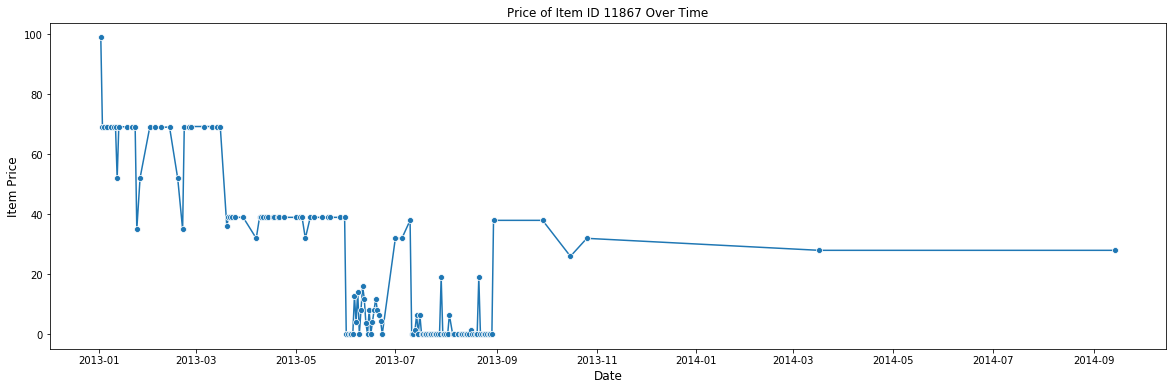

In [143]:
def plot_price_over_time(item):
    avg_item_prices_by_day = sales.groupby(['date','item_id'])['item_price'].mean().reset_index()
    plt.figure(figsize=(20,6))
    ax = sns.lineplot(avg_item_prices_by_day[avg_item_prices_by_day.item_id == item]['date'],
                      avg_item_prices_by_day[avg_item_prices_by_day.item_id == item]['item_price'],
                     marker="o")
    plt.title(f"Price of Item ID {item} Over Time")
    plt.ylabel("Item Price", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.show()
    
plot_price_over_time(11867)

In [66]:
# Given that a price may change dramatically over time for one product across all shops, let's calculate the coefficient of variation for each item separately.
coef_of_var_by_item = sales.groupby('item_id')['item_price'].agg(variation)

In [76]:
coef_of_var_by_item = coef_of_var_by_item.sort_values(ascending=False).reset_index().rename(columns={'item_price':'coef_var'})

In [77]:
coef_of_var_by_item[:10]

,item_id,coef_var
0,11860,4.016808
1,11872,3.369133
2,11866,3.057146
3,11855,2.517692
4,11856,2.338980
5,11863,2.308525
6,20144,2.299439
7,11859,2.259172
8,11853,2.228884
9,11365,2.177925


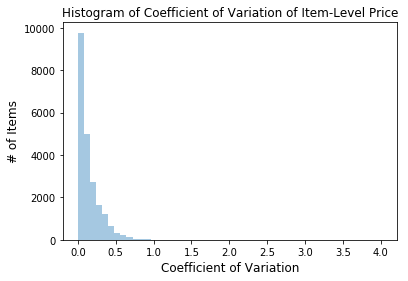

In [137]:
plt.figure(figsize=(6,4))
ax = sns.distplot(coef_of_var_by_item.coef_var, kde=False)
plt.title("Histogram of Coefficient of Variation of Item-Level Price")
plt.xlabel("Coefficient of Variation", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

In [163]:
len(coef_of_var_by_item[coef_of_var_by_item.coef_var == 0.]) / len(coef_of_var_by_item)

0.2717476039803733

**FINDING:** Consistent with the earlier finding that about 3/4 of items had different prices in the dataset, 27.17% of items show a 0 for coefficient of variation (i.e., no differences in price).

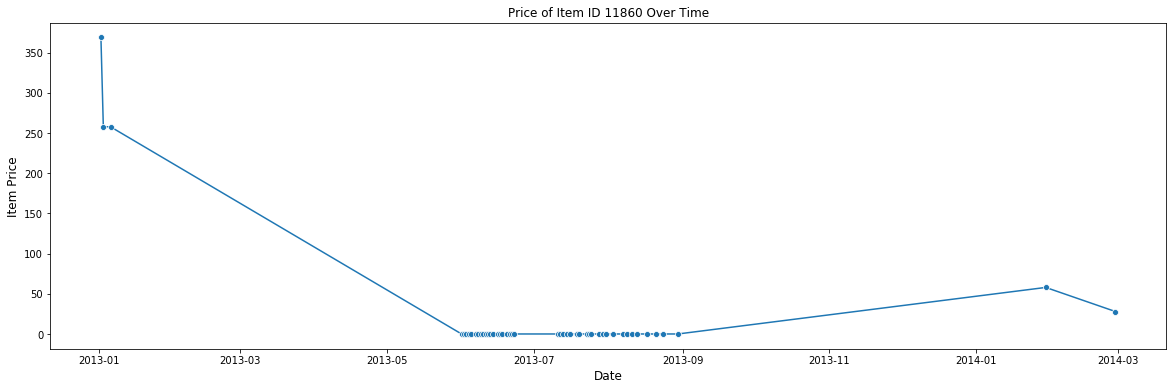

In [144]:
# Let's plot trends in prices for a couple of items with the highest coefficient of variation.
plot_price_over_time(11860)

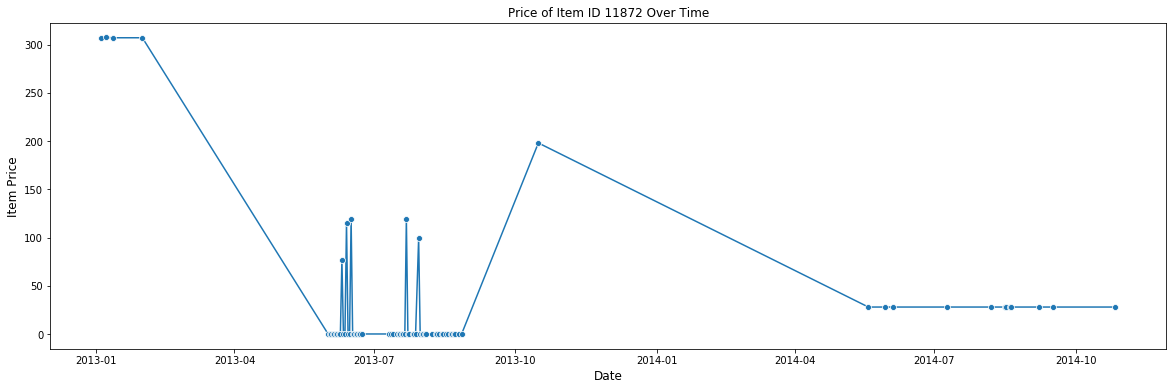

In [145]:
plot_price_over_time(11872)

**FINDING:** It appears that at least some of the large changes in price for an item are associated with a large gap between dates when that item was sold.

In [185]:
# As we did with the price column, it is helpful to examine the volatility of the quantity sold for each item.
# This will not be possible with the coefficient of variation metric because of negative quantity values sometimes resulting in the 0 mean.
# Instead, let's utilize the mean absolute deviation metric.
quantity_mad_by_item = sales.groupby('item_id')['item_cnt_day'].mad()

quantity_mad_by_item = quantity_mad_by_item.sort_values(ascending=False).reset_index().rename(columns={'item_cnt_day':'quant_mad'})

quantity_mad_by_item[:10]

,item_id,quant_mad
0,19437,63.779614
1,19445,53.927083
2,9248,42.994356
3,9249,42.895996
4,4392,38.857143
5,4201,35.555556
6,4358,35.500000
7,3730,35.069252
8,19446,33.728532
9,10199,30.400000


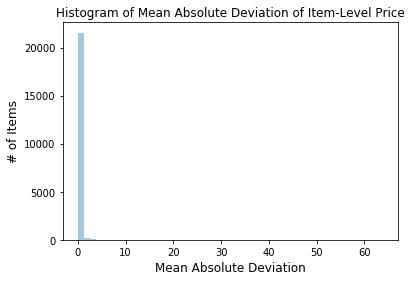

In [189]:
plt.figure(figsize=(6,4))
ax = sns.distplot(quantity_mad_by_item.quant_mad, kde=False)
plt.title("Histogram of Mean Absolute Deviation of Item-Level Price")
plt.xlabel("Mean Absolute Deviation", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

In [190]:
len(quantity_mad_by_item[quantity_mad_by_item.quant_mad == 0.]) / len(quantity_mad_by_item)

0.564405924703077

**FINDING:** 56.4% of items show a mean absolute deviation of 0.

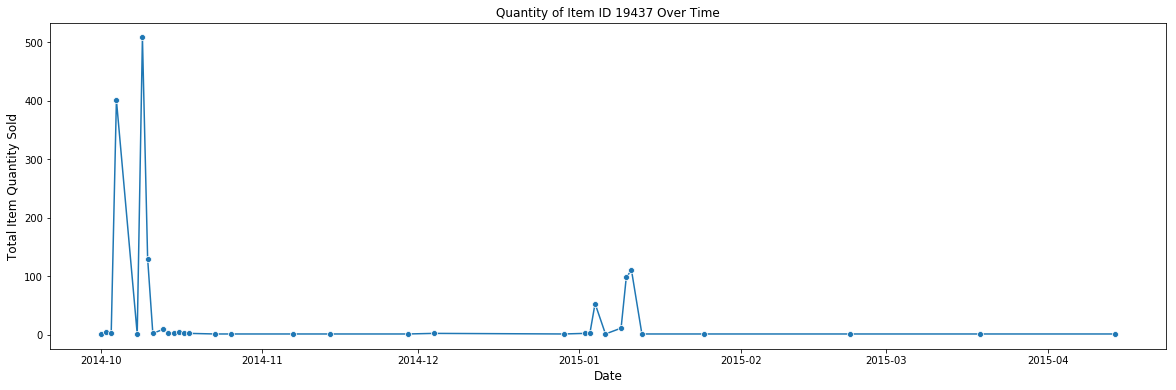

In [192]:
# Let's plot trends in total quantity sold for a couple of items with the highest mean absolute deviation.

def plot_quantity_over_time(item):
    total_item_qty_by_day = sales.groupby(['date','item_id'])['item_cnt_day'].sum().reset_index()
    plt.figure(figsize=(20,6))
    ax = sns.lineplot(total_item_qty_by_day[total_item_qty_by_day.item_id == item]['date'],
                      total_item_qty_by_day[total_item_qty_by_day.item_id == item]['item_cnt_day'],
                     marker="o")
    plt.title(f"Quantity of Item ID {item} Over Time")
    plt.ylabel("Total Item Quantity Sold", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.show()
    
plot_quantity_over_time(19437)

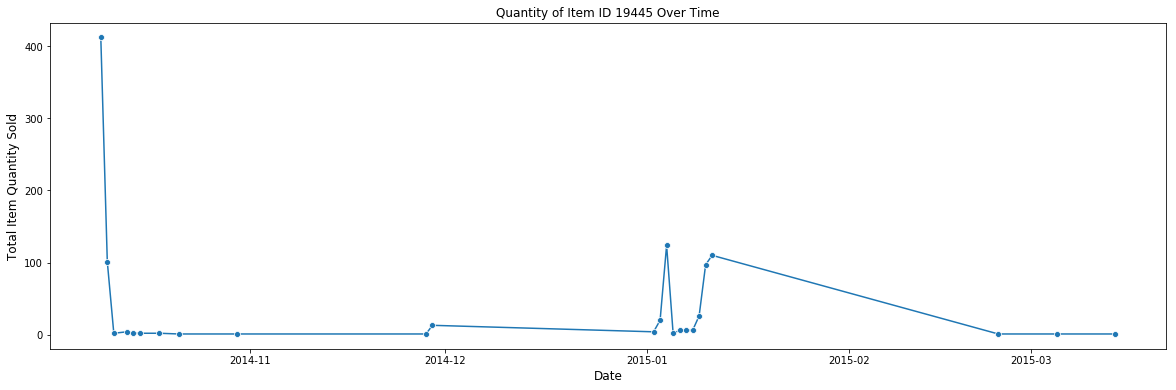

In [193]:
plot_quantity_over_time(19445)

**FINDING:** It appears that at least for some items there are random (maybe random, maybe not) short-term spikes in quantity sold. May need to investigate if these spikes are associated with anything.

In [254]:
# Let's investigate how often items are bought and how much time passes between purchases
# Calculate number of unique days on which each item was bought, and percentage of all days in the dataset
n_days_by_item = sales.groupby("item_id")["date"].unique().map(lambda x: x.size).reset_index().rename(columns={'date':'n_unique_days'})
n_days_by_item['pct_of_all_days'] = n_days_by_item.n_unique_days / ((sales.date.max() - sales.date.min()).days + 1)
n_days_by_item.head()

,item_id,n_unique_days,pct_of_all_days
0,0,1,0.000967
1,1,6,0.005803
2,2,2,0.001934
3,3,2,0.001934
4,4,1,0.000967


In [256]:
# examine the items with the highest frequency of sales
n_days_by_item.sort_values(by='pct_of_all_days', ascending=False)[:10]

,item_id,n_unique_days,pct_of_all_days
5717,5822,1033,0.999033
2263,2308,1018,0.984526
7735,7894,1006,0.972921
5718,5823,999,0.966151
5716,5821,987,0.954545
7698,7856,981,0.948743
11924,12134,972,0.940039
7734,7893,970,0.938104
2749,2808,967,0.935203
1860,1905,967,0.935203


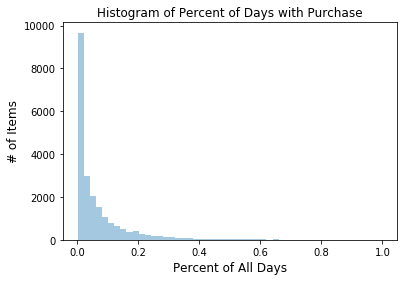

In [295]:
plt.figure(figsize=(6,4))
ax = sns.distplot(n_days_by_item.pct_of_all_days, kde=False)
plt.title("Histogram of Percent of Days with Purchase")
plt.xlabel("Percent of All Days", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

**FINDING:** There are items that were purchased on nearly all of the days in the train dataset, but those are exceptions. Most items are not purchased frequently.

In [291]:
# examine which values of number of unique days are associated with the highest counts of items
n_days_by_item.n_unique_days.value_counts().sort_values(ascending=False)[:10]

1     2381
2     1067
3      692
4      569
5      477
6      440
8      367
7      359
10     324
9      318
Name: n_unique_days, dtype: int64

**FINDING:** 2,381 items in the train dataset were bought on just one day (each).

In [282]:
unique_item_dates = sales[['item_id','shop_id','date']].drop_duplicates(subset=['item_id','date']).sort_values(by=['item_id','date'])

In [283]:
avg_time_bw_sales_by_item = unique_item_dates.groupby("item_id")["date"].apply(lambda x: x.diff().mean()).reset_index().rename(columns={'date':'avg_gap'})

In [284]:
avg_time_bw_sales_by_item.avg_gap.isnull().sum()

2381

In [287]:
# Replace missing values with 0 for items that only had one day of purchase
avg_time_bw_sales_by_item.fillna(0, inplace=True)

In [288]:
avg_time_bw_sales_by_item[:10]

,item_id,avg_gap
0,0,0 days 00:00:00
1,1,40 days 04:48:00
2,2,80 days 00:00:00
3,3,52 days 00:00:00
4,4,0 days 00:00:00
5,5,0 days 00:00:00
6,6,0 days 00:00:00
7,7,0 days 00:00:00
8,8,6 days 00:00:00
9,9,0 days 00:00:00


In [292]:
# examine which values of average number of days between purchases are associated with the highest counts of items
avg_time_bw_sales_by_item.avg_gap.dt.days.value_counts().sort_values(ascending=False)[:10]

0    2381
2    1718
1    1524
3    1511
4    1199
5    1056
6     904
7     782
8     683
9     587
Name: avg_gap, dtype: int64

In [306]:
avg_time_bw_sales_by_item.avg_gap.dt.days.describe()

count    21807.000000
mean        23.343743
std         54.577716
min          0.000000
25%          2.000000
50%          7.000000
75%         21.000000
max        978.000000
Name: avg_gap, dtype: float64

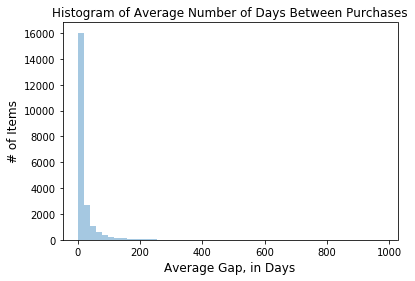

In [304]:
plt.figure(figsize=(6,4))
ax = sns.distplot(avg_time_bw_sales_by_item.avg_gap.dt.days, kde=False)
plt.title("Histogram of Average Number of Days Between Purchases")
plt.xlabel("Average Gap, in Days", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

**FINDING:** Again, it is a highly skewed distribution.  The mean of average gap is 23.34 days, while the median is only 7 days.  The maximum value is 978 days, so there is one item that had a gap of almost 3 years between its purchases.  Whether that is an accurate value or not is not clear.

In [312]:
# Calculate number of unique days on which each shop sold an item, and percentage of all days in the dataset
n_days_by_shop = sales.groupby("shop_id")["date"].unique().map(lambda x: x.size).reset_index().rename(columns={'date':'n_unique_days'})
n_days_by_shop['pct_of_all_days'] = n_days_by_shop.n_unique_days / ((sales.date.max() - sales.date.min()).days + 1)
n_days_by_shop.head()

,shop_id,n_unique_days,pct_of_all_days
0,0,57,0.055126
1,1,56,0.054159
2,2,1018,0.984526
3,3,1028,0.994197
4,4,1010,0.976789


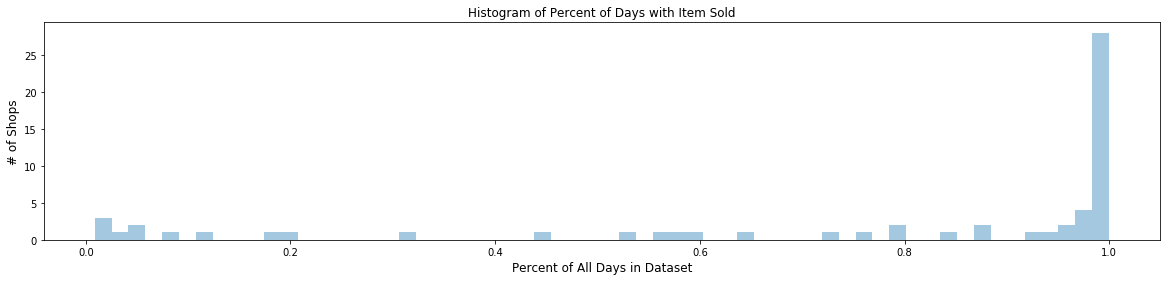

In [316]:
plt.figure(figsize=(20,4))
ax = sns.distplot(n_days_by_shop.pct_of_all_days, bins=60, kde=False)
plt.title("Histogram of Percent of Days with Item Sold")
plt.xlabel("Percent of All Days in Dataset", fontsize=12)
plt.ylabel("# of Shops", fontsize=12)
plt.show()

In [307]:
unique_shop_dates = sales[['item_id','shop_id','date']].drop_duplicates(subset=['shop_id','date']).sort_values(by=['shop_id','date'])

In [308]:
avg_time_bw_sales_by_shop = unique_shop_dates.groupby("shop_id")["date"].apply(lambda x: x.diff().mean()).reset_index().rename(columns={'date':'avg_gap'})

In [317]:
avg_time_bw_sales_by_shop.head()

,shop_id,avg_gap
0,0,1 days 00:00:00
1,1,1 days 00:26:10.909090
2,2,1 days 00:22:39.292035
3,3,1 days 00:07:00.642648
4,4,1 days 00:32:49.474727


In [324]:
shop_level_stats = avg_time_bw_sales_by_shop.merge(n_days_by_shop, on='shop_id')
shop_level_stats['avg_gap_hrs'] = shop_level_stats.avg_gap.dt.days * 24 + shop_level_stats.avg_gap.dt.seconds / 3600.
shop_level_stats.head()

,shop_id,avg_gap,n_unique_days,pct_of_all_days,avg_gap_hrs
0,0,1 days 00:00:00,57,0.055126,24.000000
1,1,1 days 00:26:10.909090,56,0.054159,24.436111
2,2,1 days 00:22:39.292035,1018,0.984526,24.377500
3,3,1 days 00:07:00.642648,1028,0.994197,24.116667
4,4,1 days 00:32:49.474727,1010,0.976789,24.546944


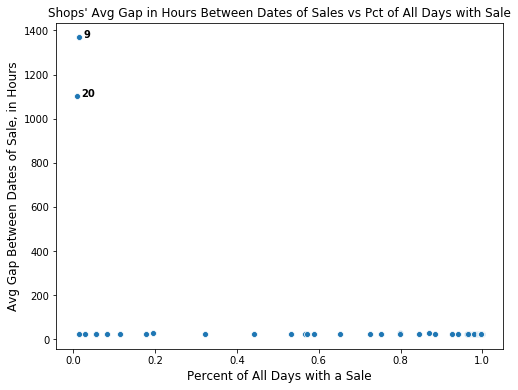

In [337]:
plt.figure(figsize=(8,6))
ax = sns.scatterplot(data=shop_level_stats, x="pct_of_all_days", y="avg_gap_hrs")

# display shop_id values for the two outlier shops in the plot
for line in range(shop_level_stats.shape[0]):
    if shop_level_stats.loc[line,'avg_gap_hrs'] > 200:
        ax.text(shop_level_stats.pct_of_all_days[line]+0.01, shop_level_stats.avg_gap_hrs[line], 
        shop_level_stats.shop_id[line], horizontalalignment='left', 
        size='medium', color='black', weight='semibold')

plt.title("Shops' Avg Gap in Hours Between Dates of Sales vs Pct of All Days with Sale")
plt.xlabel("Percent of All Days with a Sale", fontsize=12)
plt.ylabel("Avg Gap Between Dates of Sale, in Hours", fontsize=12)
plt.show()

In [339]:
shop_level_stats[shop_level_stats.avg_gap_hrs < 200].avg_gap_hrs.max()

29.96361111111111

**FINDING:** Nearly all shops have just about a 1-day average gap between sales (i.e., they sell items just about every day), but there is a couple of shops with the average gap above 1,000 hours (over 40 days).  We'll need to examine those two shops more closely later.

In [341]:
# Let's also examine how each shop's overall span between first and last dates of sales looks.
shop_level_stats['first_date'] = sales.groupby('shop_id')['date'].min()
shop_level_stats['last_date'] = sales.groupby('shop_id')['date'].max()

In [342]:
shop_level_stats.head()

,shop_id,avg_gap,n_unique_days,pct_of_all_days,avg_gap_hrs,first_date,last_date
0,0,1 days 00:00:00,57,0.055126,24.000000,2013-01-03,2013-02-28
1,1,1 days 00:26:10.909090,56,0.054159,24.436111,2013-01-03,2013-02-28
2,2,1 days 00:22:39.292035,1018,0.984526,24.377500,2013-01-01,2015-10-31
3,3,1 days 00:07:00.642648,1028,0.994197,24.116667,2013-01-02,2015-10-31
4,4,1 days 00:32:49.474727,1010,0.976789,24.546944,2013-01-02,2015-10-31


In [343]:
shop_level_stats.dtypes

shop_id                      int64
avg_gap            timedelta64[ns]
n_unique_days                int64
pct_of_all_days            float64
avg_gap_hrs                float64
first_date          datetime64[ns]
last_date           datetime64[ns]
dtype: object

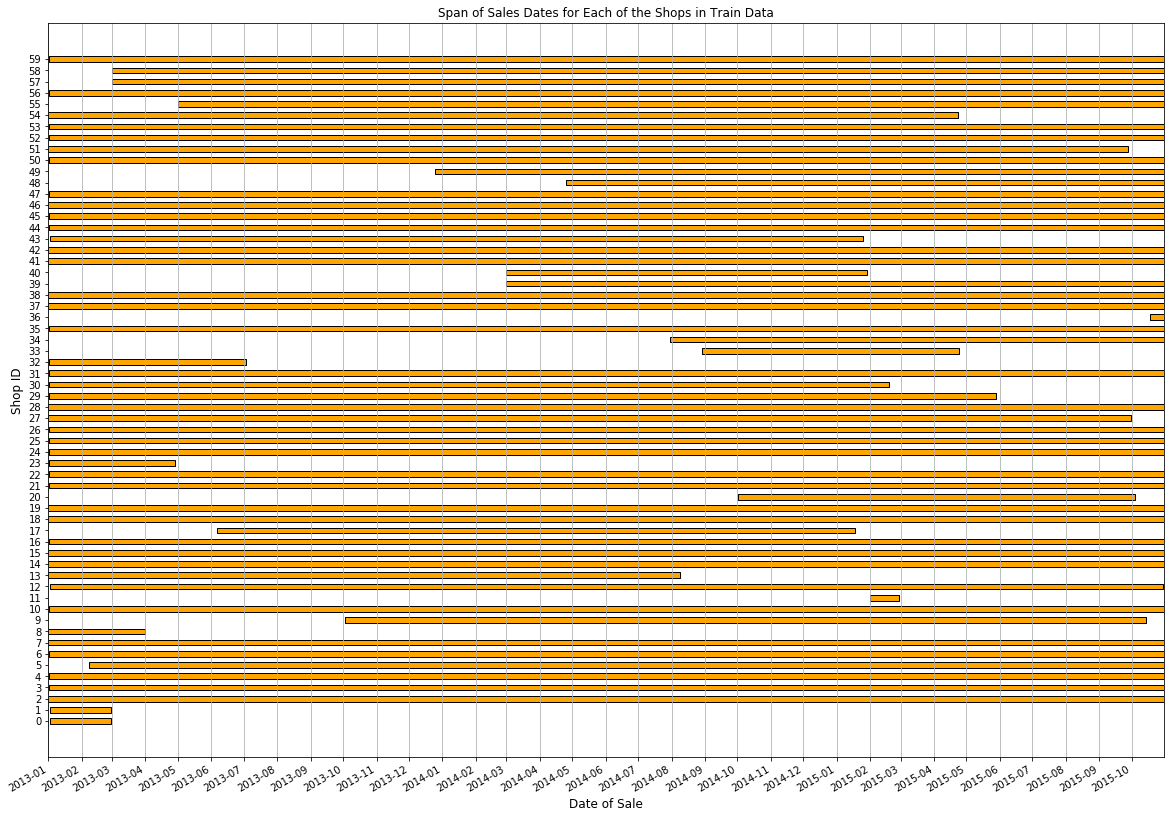

In [406]:
bdate = [t for t in shop_level_stats['first_date'] ]
edate = [t for t in shop_level_stats['last_date'] ]

# Now convert them to matplotlib's internal format...
edate, bdate = [mdates.date2num(item) for item in (edate, bdate)]

ypos = range(len(edate))

fig, ax = plt.subplots(figsize = (20, 15))

ax.grid(axis='x')

# Plot the data
ax.barh(ypos, edate - bdate, left=bdate, height=0.5, align='center', color="orange", edgecolor="black")
ax.axis('tight')
ax.set_yticks([i for i in shop_level_stats.index])
#ax.set_xticks([i for i in shop_level_stats.fir])

# Formatters for x-axis labels
months = mdates.MonthLocator()  # every month
date_fmt = mdates.DateFormatter('%Y-%m')
# We need to tell matplotlib that these are dates...
ax.xaxis_date()
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(date_fmt)
fig.autofmt_xdate()
ax.set_xlim(shop_level_stats.first_date.min(), shop_level_stats.last_date.max())

plt.title("Span of Sales Dates for Each of the Shops in Train Data")
plt.xlabel("Date of Sale", fontsize=12)
plt.ylabel("Shop ID", fontsize=12)

plt.show()

**FINDING:** We can see that there are 18 shops that stopped selling before the last day in the train dataset.

### TEST DATASET 

In [91]:
test_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/test.csv')

In [92]:
test_df.shape

(214200, 3)

In [93]:
test_df.head(10)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [114]:
test_df.duplicated().any()

False

**FINDING:** No duplicates in the test dataset

In [115]:
test_df.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

**FINDING:** No missing values in the test dataset

In [94]:
len(test_df.shop_id.unique())

42

In [97]:
len(test_df.item_id.unique())

5100

**FINDING:** The test dataset is created by including all possible combinations of the shop_id and item_ids in the dataset (i.e., 42 * 5,100 = 214,200). Why those 42 shops and 5,100 items are part of this test dataset is not clear though.

In [98]:
np.setdiff1d(test_df.shop_id.unique(), sales.shop_id.unique())

array([], dtype=int64)

**FINDING:** All shop_id values in the test dataset also exist in the train dataset.

In [99]:
np.setdiff1d(sales.shop_id.unique(), test_df.shop_id.unique())

array([ 0,  1,  8,  9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51,
       54])

**FINDING:** 18 shop_id values above exist in the train dataset but do not exist in the test dataset.

In [101]:
np.setdiff1d(test_df.item_id.unique(), sales.item_id.unique()).size

363

**FINDING:** 363 item_id values exist in the test dataset, but do not exist in the train dataset.

In [104]:
np.setdiff1d(sales.item_id.unique(), test_df.item_id.unique()).size

17070

**FINDING:** 17,070 item_id values exist in the train dataset, but do not exist in the test dataset.

In [133]:
np.intersect1d(sales.item_id.unique(), test_df.item_id.unique()).size

4737

**FINDING:** 4,737 item_id values exist in both the train and test datasets.

### ITEMS SUPPLEMENTAL INFORMATION DATASET 

In [105]:
items_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/items.csv')

In [106]:
items_df.shape

(22170, 3)

In [126]:
items_df.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [148]:
# Need to check if all item_ids (in train and test datasets) exist in the items_df dataset
np.setdiff1d(sales.item_id.unique(), items_df.item_id.unique()).size

0

In [149]:
np.setdiff1d(test_df.item_id.unique(), items_df.item_id.unique()).size

0

**FINDING:** All item_id values in the train and test datasets exist in the items_df dataset.

### ITEM CATEGORIES DATASET

In [108]:
categories_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/item_categories.csv')

In [109]:
categories_df.shape

(84, 2)

In [110]:
categories_df.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [112]:
categories_df.duplicated().any()

False

In [113]:
categories_df.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [116]:
categories_df.item_category_id.unique().size

84

In [127]:
categories_df.item_category_name.unique().size

84

**FINDING:** No duplicates or missing values in the categories_df dataset. Also, category names and category ids are all unique.

In [150]:
# Check if all categories of item_ids in train and test datasets also all exist in the categories_df dataset
np.setdiff1d(items_df.item_category_id.unique(), categories_df.item_category_id.unique()).size

0

**FINDING:** All categories of item_ids in the items_df dataset exist in the categories_df dataset.

In [165]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [170]:
# Check if there are categories of the 363 items that only appear in the test dataset that also only apply those 363 items.
items_only_in_test_df = np.setdiff1d(test_df.item_id.unique(), sales.item_id.unique())

cats_of_items_only_in_test_df = items_df[items_df.item_id.isin(items_only_in_test_df)]['item_category_id'].unique()

items_in_train_df = sales.item_id.unique()

cats_of_items_in_train_df = items_df[items_df.item_id.isin(items_in_train_df)]['item_category_id'].unique()

np.setdiff1d(cats_of_items_only_in_test_df, cats_of_items_in_train_df)

array([], dtype=int64)

**FINDING:** All categories of the 363 items that only appear in the test dataset also apply to items in the train dataset.

In [129]:
list(categories_df.item_category_name)

['PC - Гарнитуры/Наушники',
 'Аксессуары - PS2',
 'Аксессуары - PS3',
 'Аксессуары - PS4',
 'Аксессуары - PSP',
 'Аксессуары - PSVita',
 'Аксессуары - XBOX 360',
 'Аксессуары - XBOX ONE',
 'Билеты (Цифра)',
 'Доставка товара',
 'Игровые консоли - PS2',
 'Игровые консоли - PS3',
 'Игровые консоли - PS4',
 'Игровые консоли - PSP',
 'Игровые консоли - PSVita',
 'Игровые консоли - XBOX 360',
 'Игровые консоли - XBOX ONE',
 'Игровые консоли - Прочие',
 'Игры - PS2',
 'Игры - PS3',
 'Игры - PS4',
 'Игры - PSP',
 'Игры - PSVita',
 'Игры - XBOX 360',
 'Игры - XBOX ONE',
 'Игры - Аксессуары для игр',
 'Игры Android - Цифра',
 'Игры MAC - Цифра',
 'Игры PC - Дополнительные издания',
 'Игры PC - Коллекционные издания',
 'Игры PC - Стандартные издания',
 'Игры PC - Цифра',
 'Карты оплаты (Кино, Музыка, Игры)',
 'Карты оплаты - Live!',
 'Карты оплаты - Live! (Цифра)',
 'Карты оплаты - PSN',
 'Карты оплаты - Windows (Цифра)',
 'Кино - Blu-Ray',
 'Кино - Blu-Ray 3D',
 'Кино - Blu-Ray 4K',
 'Кино - DV

**FINDING:** It appears that there are groups of categories, like game consoles, movies, books, gifts, etc.  It will likely be very important to know when certain movies are released and what their popularity is, for example, as well as when new game consoles are introduced, etc.

In [154]:
# Testing filtering categories by the the first word in their name
mask = categories_df.item_category_name.str.startswith("Аксессуары")
categories_df.item_category_name[mask]

1         Аксессуары - PS2
2         Аксессуары - PS3
3         Аксессуары - PS4
4         Аксессуары - PSP
5      Аксессуары - PSVita
6    Аксессуары - XBOX 360
7    Аксессуары - XBOX ONE
Name: item_category_name, dtype: object

### SHOPS SUPPLEMENTAL INFORMATION DATASET

In [117]:
shops_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/shops.csv')

In [118]:
shops_df.shape

(60, 2)

In [119]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [121]:
shops_df.duplicated().any()

False

In [122]:
shops_df.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [123]:
shops_df.shop_id.unique().size

60

**FINDING:** There are no duplicates or missing values in the shops_df dataset.

In [124]:
shops_df.shop_name

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

**FINDING:** It appears that these shops are located in different parts of Russia and that it may be possible to identify specific locations, at least at city level. There may be online stores too.

### MACROECONOMIC DATA FROM SBERBANK COMPETITION 

In [195]:
macro_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/macro.csv')

In [196]:
macro_df.shape

(2484, 100)

In [197]:
macro_df.columns

Index(['timestamp', 'oil_urals', 'gdp_quart', 'gdp_quart_growth', 'cpi', 'ppi',
       'gdp_deflator', 'balance_trade', 'balance_trade_growth', 'usdrub',
       'eurrub', 'brent', 'net_capital_export', 'gdp_annual',
       'gdp_annual_growth', 'average_provision_of_build_contract',
       'average_provision_of_build_contract_moscow', 'rts', 'micex',
       'micex_rgbi_tr', 'micex_cbi_tr', 'deposits_value', 'deposits_growth',
       'deposits_rate', 'mortgage_value', 'mortgage_growth', 'mortgage_rate',
       'grp', 'grp_growth', 'income_per_cap',
       'real_dispos_income_per_cap_growth', 'salary', 'salary_growth',
       'fixed_basket', 'retail_trade_turnover',
       'retail_trade_turnover_per_cap', 'retail_trade_turnover_growth',
       'labor_force', 'unemployment', 'employment',
       'invest_fixed_capital_per_cap', 'invest_fixed_assets',
       'profitable_enterpr_share', 'unprofitable_enterpr_share',
       'share_own_revenues', 'overdue_wages_per_cap', 'fin_res_per_cap',
    

In [198]:
macro_df.timestamp.head()

0    2010-01-01
1    2010-01-02
2    2010-01-03
3    2010-01-04
4    2010-01-05
Name: timestamp, dtype: object

In [199]:
#convert timestamp values to datetime
macro_df['datetime'] = pd.to_datetime(macro_df.timestamp)

In [200]:
macro_df.datetime.describe()

count                    2484
unique                   2484
top       2015-10-18 00:00:00
freq                        1
first     2010-01-01 00:00:00
last      2016-10-19 00:00:00
Name: datetime, dtype: object

In [202]:
#check that there is datetime value for each day between the first and last day in the macro dataset
lastday = datetime.date(2016,10,19)
firstday = datetime.date(2010,1,1)
delta = lastday - firstday
print(delta.days + 1)

2484


**FINDING:** There is a row for every date between Jan 1, 2010 an Oct 19, 2016 in the macro_df dataset.

In [203]:
# Let's check which columns have missing values and how often.
miss_vls_macro = pd.DataFrame(macro_df.isnull().sum(axis=0).sort_values(ascending=False), columns=['Count'])
miss_vls_macro['Percent'] = miss_vls_macro['Count'].apply(lambda x: '{:.2f}%'.format((float(x) / macro_df.shape[0]) * 100))
miss_vls_macro[miss_vls_macro.Count > 0]

,Count,Percent
provision_retail_space_modern_sqm,1754,70.61%
provision_retail_space_sqm,1753,70.57%
old_education_build_share,1389,55.92%
modern_education_share,1389,55.92%
population_reg_sports_share,1023,41.18%
museum_visitis_per_100_cap,1023,41.18%
theaters_viewers_per_1000_cap,1023,41.18%
students_reg_sports_share,1023,41.18%
hospital_bed_occupancy_per_year,1023,41.18%
hospital_beds_available_per_cap,1023,41.18%


In [204]:
# Identify features without any missing values
miss_vls_macro[miss_vls_macro.Count == 0]

,Count,Percent
oil_urals,0,0.00%
datetime,0,0.00%
gdp_annual,0,0.00%
gdp_annual_growth,0,0.00%
average_provision_of_build_contract,0,0.00%
deposits_value,0,0.00%
mortgage_value,0,0.00%
mortgage_rate,0,0.00%
fixed_basket,0,0.00%
timestamp,0,0.00%


In [12]:
# Aggregate to monthly level the required metrics
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0